<a href="https://colab.research.google.com/github/CleanPegasus/3D-GAN/blob/master/3D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip

--2019-05-19 14:30:41--  https://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip
Resolving 3dshapenets.cs.princeton.edu (3dshapenets.cs.princeton.edu)... 128.112.136.51
Connecting to 3dshapenets.cs.princeton.edu (3dshapenets.cs.princeton.edu)|128.112.136.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533450062 (509M) [application/zip]
Saving to: ‘3DShapeNetsCode.zip’

3DShapeNetsCode.zip 100%[===================>] 508.74M  96.4MB/s    in 5.5s    

2019-05-19 14:30:46 (93.2 MB/s) - ‘3DShapeNetsCode.zip’ saved [533450062/533450062]



In [0]:
ls

3DShapeNetsCode.zip  sample_data/


In [0]:
!unzip 3DShapeNetsCode.zip

In [0]:
ls

3DShapeNets/  3DShapeNetsCode.zip  sample_data/


In [0]:
import scipy.io as io
import scipy.ndimage as nd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [0]:
voxels = io.loadmat("3DShapeNets/volumetric_data/xbox/30/train/xbox_000000340_1.mat")['instance']

In [0]:
voxels = np.pad(voxels, (1, 1), 'constant', constant_values = (0, 0))

In [0]:
voxels = nd.zoom(voxels, (2, 2, 2), mode = 'constant', order = 0)

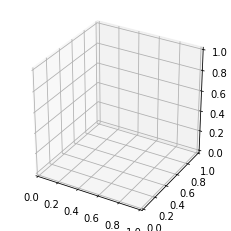

In [0]:
fig = plt.figure()
ax = fig.gca(projection = "3d")
ax.set_aspect('equal')

In [0]:
ax.voxels(voxels, edgecolor = 'red')

{(10, 28, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0fece7b8>,
 (10, 28, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0fee1cf8>,
 (10, 29, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0ff71898>,
 (10, 29, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0ff71b00>,
 (10, 30, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0febb048>,
 (10, 30, 11): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf252e1518>,
 (10, 31, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0fed8438>,
 (10, 31, 11): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0feedba8>,
 (11, 28, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0feed710>,
 (11, 28, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0feed080>,
 (11, 29, 10): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0feed2b0>,
 (11, 29, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fbf0feed908>,
 (11, 30, 10): <mpl_toolkits.mplot3d.art

In [0]:
import glob
import os

In [0]:
import time
import tensorflow as tf
from keras import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv3D, Deconv3D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import matplotlib

In [0]:
def build_gen():
  
  
  z_size = 200
  gen_filters = [512, 256, 128, 64, 1]
  gen_strides = [1, 2, 2, 2, 2]
  gen_input_shape = (1, 1, 1, z_size)
  gen_activations = ['relu', 'relu', 'relu', 'relu', 'sigmoid']
  
  
  input_layer = Input(shape = gen_input_shape)
  
  x = Deconv3D(filters = 512, kernel_size = 4, strides = 1)(input_layer)
  x = BatchNormalization()(a, training = True)
  x = Activation(activation = 'relu')(a)
  
  x = Deconv3D(filters = 256, kernel_size = 4, strides = 2, padding = 'same')(input_layer)
  x = BatchNormalization()(a, training = True)
  x = Activation(activation = 'relu')(a)
  
  x = Deconv3D(filters = 128, kernel_size = 4, strides = 2, padding = 'same')(input_layer)
  x = BatchNormalization()(a, training = True)
  x = Activation(activation = 'relu')(a)
  
  
  x = Deconv3D(filters = 64, kernel_size = 4, strides = 2, padding = 'same')(input_layer)
  x = BatchNormalization()(a, training = True)
  x = Activation(activation = 'relu')(a)
  
  x = Deconv3D(filters = 1, kernel_size = 4, strides = 2, padding = 'same')(input_layer)
  x = BatchNormalization()(a, training = True)
  x = Activation(activation = 'sigmoid')(a)
  
  output = a
  
  gen_model = Model(inputs = input_layer, outputs = output)
  gen_model.summary()
  
  return gen_model

In [0]:
def build_disc():
  
  disc_input_shape = (64, 64, 64, 1)
  disc_filters = [64, 128, 256, 512, 1]
  disc_padding = ['same', 'same', 'same', 'same', 'valid']
  disc_convolutional_blocks = 5
  
  disc_input_layer = Input(shape = disc_input_shape)
  
  x = Conv3D(filters = 64, kernel_size = 4, strides = 2, padding = 'same')(disc_input_layer)
  x = BatchNormalization()(x, training = True)
  x = LeakyReLU(0.2)(x)
  
  x = Conv3D(filters = 128, kernel_size = 4, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x, training = True)
  x = LeakyReLU(0.2)(x)
  
  x = Conv3D(filters = 256, kernel_size = 4, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x, training = True)
  x = LeakyReLU(0.2)(x)
  
  x = Conv3D(filters = 512, kernel_size = 4, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x, training = True)
  x = LeakyReLU(0.2)(x)
  
  x = Conv3D(filters = 1, kernel_size = 4, strides = 2, padding = 'valid')(x)
  x = BatchNormalization()(x, training = True)
  x = LeakyReLU(0.2)(x)
  
  output = x
  
  disc_model = Model(inputs = disc_input_layer, outputs = output)
  
  disc_model.summary()
  
  return disc_model

In [0]:
def write_logs(callback, name, value, batch_no):
  summary = tf.Summary()
  summary_value = summery_value.add()
  summery_value.simple_value = value
  summary_value.tag = name
  callback.writer.add_summary(summary, batch_no)
  call_back.writer.flush()

In [0]:
def get3DImages(data_dir):
  all_files = np.random.choice(glob.glob(data_dir), size = 10)
  
  for f in all_files:
    all_volumes = np.asarray(getVoxelFromMat(f), dtype = np.bool)
    
  return all_volumes

In [0]:
def getVoxelsFromMat(path, cube_len = 64):
  voxels= io.loadmat(path)['instance']
  voxels = np.pad(voxels, (1, 1), 'constant', constant_values = (0, 0))
  voxels = nd.zoom(voxels, (2, 2, 2), mode = 'constant', order = 0)
  return voxels

In [0]:
def saveFromVoxels(voxels, path):
  z,x, y = voxels.nonzero()
  fig = plt.figure()
  ax = fig.add_subplot(111, projection = '3d')
  ax.scatter(x, y, -z, zdir='z', c = 'red')
  plt.savefig(path)

In [0]:
def plotAndSaveVoxel(file_path, voxel):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    ax.voxels(voxel, edgecolor="red")
    plt.show()
    plt.savefig(file_path)

In [0]:
def train():
  
  gen_learning_rate = 0.0025
  disc_learning_rate = 0.00001
  beta = 0.5
  batch_size = 32
  z_size = 200
  object_name = "chair"
  data_dir = "data/3DShapeNets/volumetric_data/" \
             "{}/30/train/*.mat".format(object_name)
  generated_volumes_dir = 'generated_volumes'
  log_dir = 'logs'
  
  
  
  generator = build_gen()
  discriminator = build_disc()
  
  gen_optimizer = Adam(lr = gen_learning_rate, beta_1 = beta)
  disc_optimizer = Adam(lr = disc_learnong_rate, beta_1 = beta)
  
  generator.compile(loss = "binary_crossentropy", optimizer = gen_optimizer)
  discriminator.compile(loss = "binary_crossentropy", optimizer = disc_optimizer)
  
  discriminator.trainable = False
  
  input_layer = Input(shape = (1, 1, 1, z_size))
  generated_volumes = generator(input_layer)
  validity = discriminator(generated_volumes)
  adversarial_model = Model(inputs = input_layer, outputs = validity)
  adversarial_model.compile(loss = 'binary_crossentropy', optimizer = gen_optimizer)
  
  